# [ICTCOG AI Academy] 7기 고급시각저녁반
# Pix2Pix, CycleGAN

### Pix2Pix
- 활용 측면에서의 문제점
  - **학습 데이터 세트가 반드시 한 쌍으로 짝을 이뤄야해서 구하기 힘듦**
    - 비현실적
### Generator
#### U-net
- instance segmentation의 하나
- autoencoder 구조와 유사함 
- 다른점은 skip connection

- 동일한 위치의 값을 받아서 이미지 생성식 원본가 비슷하게 생성하는 생성모델
  - Encoder : (Conv -> Batchnorm -> Leaky ReLU)
      - Batch Normalizaiton activation 전에 normalizaitaon 해서 깊은 레이어에서도 학습 잘 됨.
  - Decoder: (Transposed Conv -> Batchnorm -> Dropout)
    - Dropout : ensemble 효과 
> - Resnet의 Residual Block
    - catastrophic forgetting 문제로 short cut 으로유지

In [ ]:
OUTPUT_CHANNELS = 3

##### Initializer
- Numerical Stability and Initialization 
- 학습 안 되는 경우 중요!

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

#Encoder : (Conv -> Batchnorm -> Leaky ReLU)
  result = tf.keras.Sequential()
  
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


#### Conv2DTranspose
- 다양한 upsampling 방법 : upsampling, Conv2DTranspose
- **upsampling 하고 학습을 통해서 복원**
  - 좀 더 정확히 복원

> dialated convolution, depth-wise convolution, separable convolution


In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add( tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same', kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU()) #relu (다양한 실험의 결과
  return result

아직은 사람이 직접 정해서 체크 하는게 자동보다 성능 제일 좋음

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
    downsample(128, 4),  # (bs, 64, 64, 128)
    downsample(256, 4),  # (bs, 32, 32, 256)
    downsample(512, 4),  # (bs, 16, 16, 512)
    downsample(512, 4),  # (bs, 8, 8, 512)
    downsample(512, 4),  # (bs, 4, 4, 512)
    downsample(512, 4),  # (bs, 2, 2, 512)
    downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
    upsample(512, 4),  # (bs, 16, 16, 1024)
    upsample(256, 4),  # (bs, 32, 32, 512)
    upsample(128, 4),  # (bs, 64, 64, 256)
    upsample(64, 4),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)

  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

  x = inputs
#u-net
#for 돌이기 위해 list 형태로 만들어 놓았음 
# 
  # Downsampling 
  skips = []  #값 추가
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1]) #입력된 순서 바꾸어줌   skips.append(x)

  # Upsampling & the skip connections
  for up, skip in zip(up_stack, skips): #묶어줌
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip]) #Concatenate :multi-inputs 합침

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

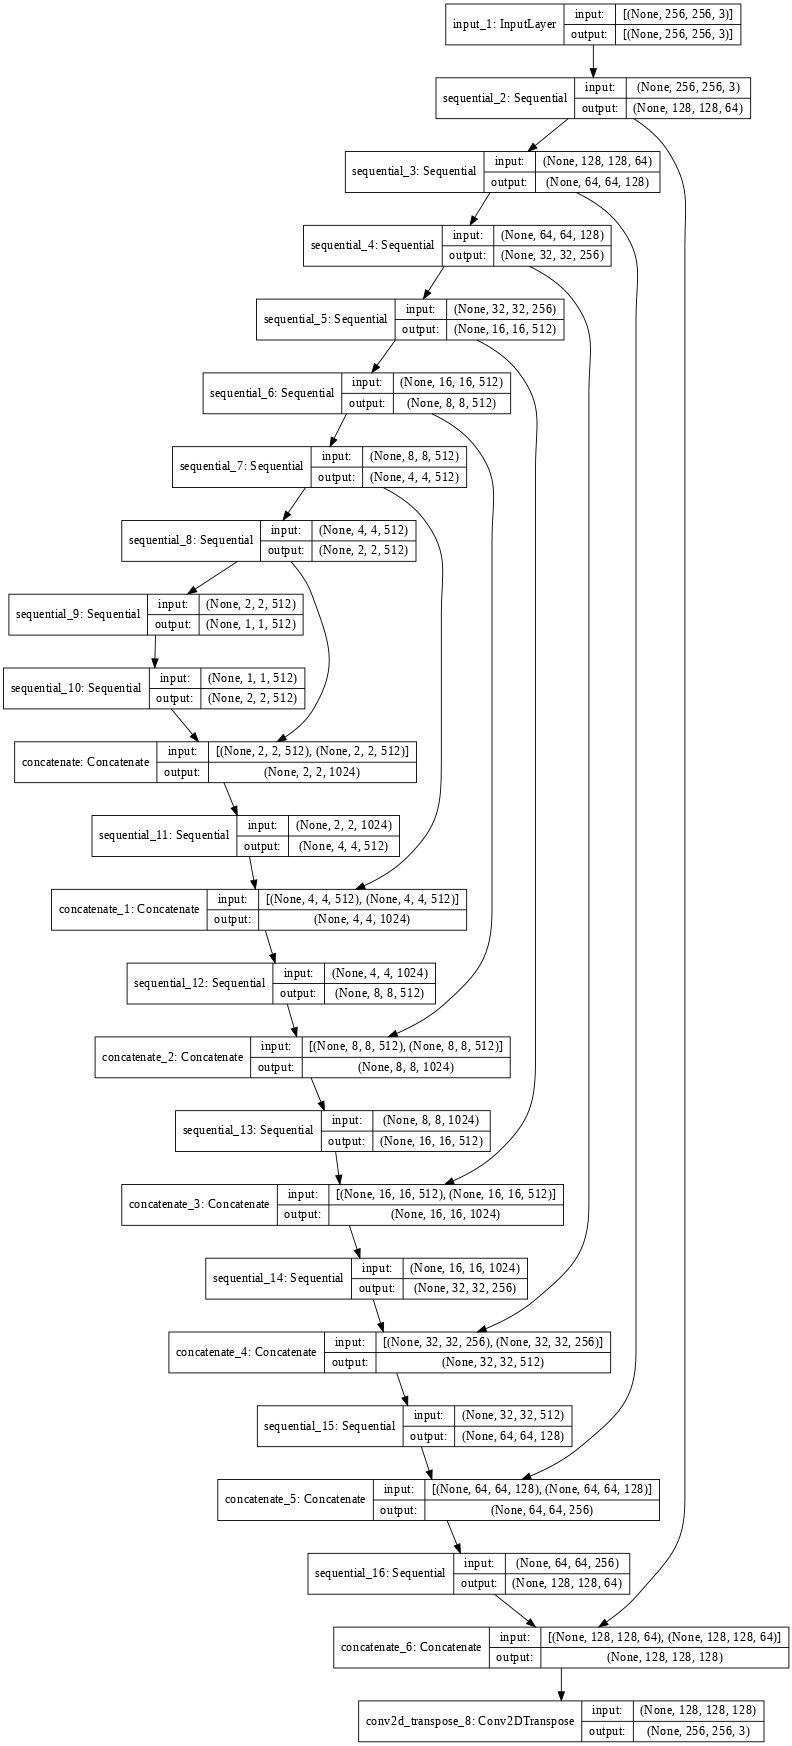

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


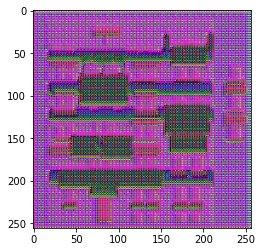

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False) 
plt.imshow(gen_output[0, ...])

* **Generator 손실(loss)**
> - GAN 의 loss 는 생성자와 판별자의 loss 2가지로 나뉘어짐


*  L1 loss : mean absolute error(MAE)
  - 값이 너무 크게 변하는 것을 방지
* loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100

In [ ]:
LAMBDA = 100

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  #실제값 1, 
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error(MAE)
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output)) #각각 더해서 평균 구함

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

- 입력된 이미지를 기반으로 생성하고 판별함
- 타겟 이미지와 비교해서 얼마나 가까운지 계산
- total loss 계산해서 다시 generator
> GAN 구조와 유사함

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


### Discriminator 
#### PatchGAN
- 이미지 전체가 아닌 patch 내의 유사한 특징들을 이용하여 복원(거리가 가까울 수록 관련성이 높다고 가정) 
* Discriminator : (Conv -> BatchNorm -> Leaky ReLU)
* Discriminator 입력 2개 받아서 Concatenate 
  - 점(pixel)단위로 잘 만들었는지 확인
  - 이미지 전체를 잘 만들었는지 확인
- 출력 30x30 
- 진짜 :input& target 이미지
- 가짜 :input& 생성된 이미지

> Pixel GAN : pixel 단위로 생성, image GAN : 이미지 전체 생


In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

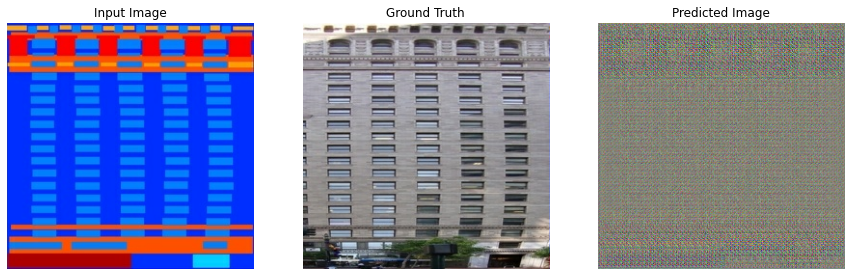

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, calculate the generator and the discriminator loss.
* Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [ ]:
EPOCHS = 150

In [ ]:
import datetime

log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

- 정답에 유사하게 생성하도록 guide
> GAN 모델 학스하는 과정과 유사

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

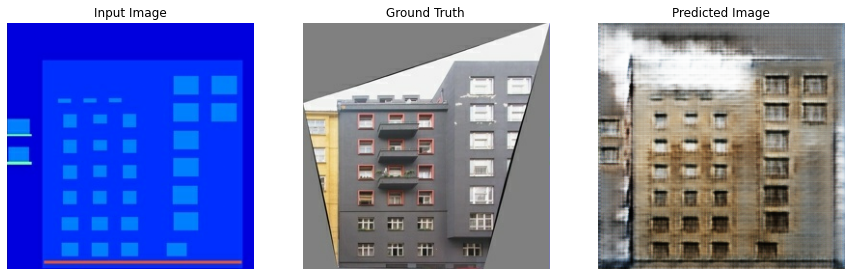

Epoch:  28
....................................................................................................
......................................................

KeyboardInterrupt: ignored

In [ ]:
import time
from IPython import display

fit(train_dataset, EPOCHS, test_dataset) #

--- 
### [CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan)
- 논문 : https://arxiv.org/abs/1703.10593
- 데이터셋:https://www.tensorflow.org/datasets/catalog/cycle_gan?hl=nb
  -  예. 말에서 얼룩말, 얼룩말에서 말로 변환
- 조건부 GAN 을 사용하여 pix2pix 처럼 2쌍의 데이터가 아니지만 서로 변환 가능
  - convolution 통해서 특징 추출
  - generator로 고유한 특징을 입혀서 이미지 생성
  - PatchGAN 의해서 특정 영역에만 특징 생성 

- pix2pix 처럼 2쌍의 데이터가 아니지만 성능은 덜 함
- CycleGAN 은 Pix2Pix만큼 성능이 좋지 않음
  - 데이터 구축이 더 쉬움
- 손실함수 구성이 복잡함함

github에서 직접 가져옴

In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
import tensorflow as tf

Pix2Pix transfer Learning 

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete2Y6T57/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete2Y6T57/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete2Y6T57/cycle_gan-testA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete2Y6T57/cycle_gan-testB.tfrecord
Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


>  Awesome 
- 공부할때 샘플 코드 참고 가능
- [Awesome TensorFlow](https://github.com/jtoy/awesome-tensorflow)

tfds에서 지도학습 형태로 데이터 불러옴

In [ ]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

pix2pix 와 같이 전처리하는 함수 따로 생성

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = random_crop(image)
  #
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
#train에는 data augmentation 적용
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

#### tf.data
- 이전처럼 map으로 적용 
- AUTOTUNE 최적화
- 캐시

In [ ]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

generator이기 때문에 for ~break , next(iter( )) 사용

In [ ]:
sample_horse = next(iter(train_horses))  #generator
sample_zebra = next(iter(train_zebras))

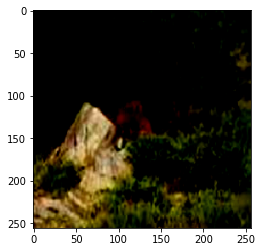

In [ ]:
for i in train_horses :
  plt.imshow(i.numpy().reshape(256,256,3))
  break

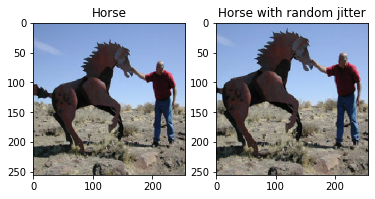

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

### Pix2Pix 모델 Transfer Learinig
- 동시에 generator, discriminator 역할을 함
- instance normalization을 사용
- 2개의  u-net 모델은 생성기이자 판별자 역할함
 

### [Normalization](https://www.tensorflow.org/addons/tutorials/layers_normalizations#:~:text=Layer%20Normalization%20(TensorFlow%20Core)%20The%20basic%20idea%20behind,activation%20layer%20to%20improve%20the%20convergence%20during%20training)
- batch, layer, instance, group, weight normalization 
  - 상황별 normalization :
  레이어가 많으면 학습 잘 안되서 학습 잘되도록 하는 테크닉Normalization](https://www.tensorflow.org/addons/tutorials/layers_normalizations#:~:text=Layer%20Normalization%20(TensorFlow%20Core)%20The%20basic%20idea%20behind,activation%20layer%20to%20improve%20the%20convergence%20during%20training)
  - batch, layer, instance, group, weight normalization 있음 

> batch normalization : 레이어가 많으면 학습 잘 안되서 학습 잘되도록 하는 테크닉
  - Relu 와 LaekyRelu와 같음

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

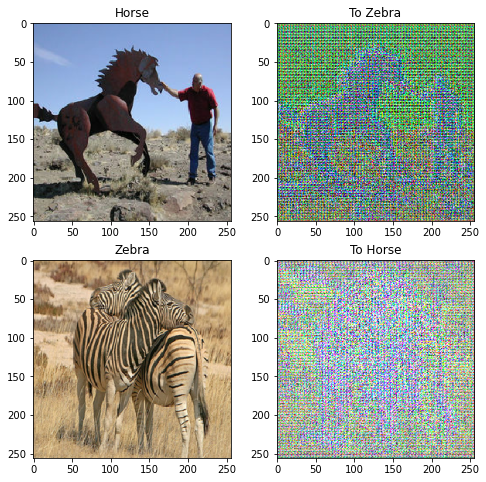

In [ ]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show() 
#성능이 좋지 않음

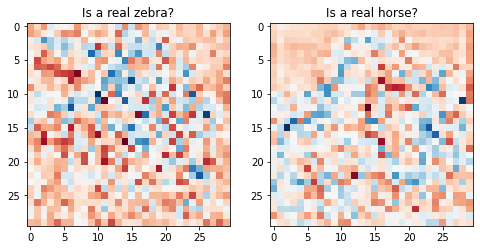

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

### loss 
- 4개의 loss
- generator loss, discriminator loss는 유사함

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated) #실제, 생성된 이미지

각 모델은 이미지를 생성한 후 다시 원본으로 생성했을때 얼마나 가까운지 계산

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

각 모델의 생성된 이미지가 얼마나 가까운지 계산

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
#optimizer
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
#훈련
EPOCHS = 40
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

generator, discriminator 2개 
- 예측
- generator loss , discrimiantor loss ,cycle loss 계산
-  2개의 generator, discriminator 각각 그래디언트를 계산
- optimizer 적용 

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))